## Кейс №2.2. РЕШЕНИЕ СИСТЕМЫ УРАВНЕНИЙ.

**Моделирование траектории движения управляемого робота**. Часть 1. Парковка

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# Импортируем необходимые библиотеки и функции из модулей
import numpy as np
np.set_printoptions(precision=3)
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
print('Last Updated On: ', datetime.datetime.now())

Last Updated On:  2021-10-18 11:44:14.918396


In [31]:
import sys
# ------------- !!! Указать папку, в которой хранятся модули !!! ---------------
sys.path.append("/content/drive/My Drive/Colab Notebooks/Calculations/Case 2.2/")
# ----------------              Загрузка модулей               -----------------
from objmodel2 import change_robot_state
from utils2 import drawDynamic2D, drawErrorDynamic, analysStrace, analysStrace_2, show_convergence_rate_plot
#from control2 import set_new_regul

### **Модель движения мобильного робота**

Рассмотрим модель движения мобильного робота (см. рис.1). 

(Модель и рисунки взяты из курса "**Control of Mobile Robots**", Magnus Egerstedt, https://www.coursera.org/)

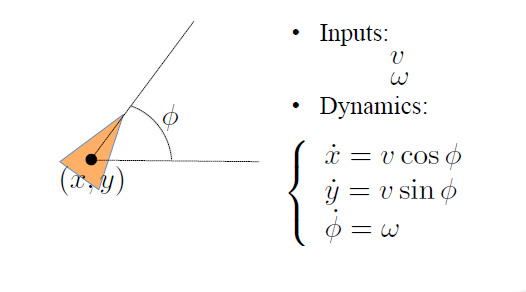

Рис.1. **Модель движения робота**. Здесь x,y - координаты центра робота, φ - направление движения соответственно; v, ω - скорость центра (м/с) и угловая скорость вращения робота вокруг центра (рад/с)

-----------

$v, ω$ - скорость центра (м/с) и угловая скорость вращения робота вокруг центра (рад/с) определяются угловыми скоростями вращения левого и правого колес робота $wL, wR$, радиусом колес $R$ и базой $L$ - расстоянием между колесами (см. рис.2) и могут быть вычислены по формулам:

$$(*) \;
\left\{
   	\begin{aligned}
       v = \frac {(wL+wR)*R}{2} \\
       w = \frac {(wR - wL)*R}{L}
	\end{aligned}
\right.
$$

----------

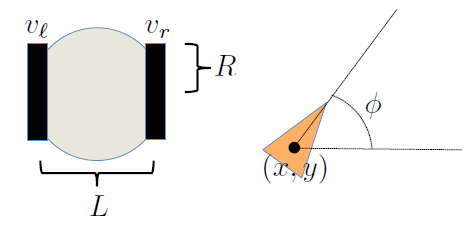

Рис.2. **Модель робота с двумя колесами**. Каждое колесо может независимо от другого вращаться со своей угловой скоростью в пределах от $w_{min}$ до $w_{max}$; $L$ - база (расстояние между колесами), $R$ - радиус колес


---------

И, наоборот, если мы знаем $v, ω$ , то можем определить - с какой угловой скоростью должны вращаться левое и правое колеса робота, чтобы обеспечить такие $v, ω$ - скорость центра (м/с) и угловую скорость вращения робота вокруг центра (рад/с):

$$(**) \;
\left\{
   	\begin{aligned}
       wL = \frac {2*v - L*w}{2*R} \\
       wR = \frac {2*v + L*w}{2*R}
	\end{aligned}
\right.
$$

------------

В данной модели мы пренебрегаем силами инерции. Мы считаем, что робот достаточно легкий и мы можем почти мгновенно раскрутить колеса робота. 

Но нужно учесть пределы возможностей моторов колес:

$$(***) \; w_{min} \le wL, wR \le w_{max}$$

------------


---------

Для примера расчетов установим параметры модели робота:


In [32]:
# -----------------------------------------------
ROBOT_L = 0.5   # БАЗА РОБОТА - расстояние между колесами
ROBOT_R = 0.5   # диаметр колеса, м
ROBOT_Wmin = 0  # минимальная угловая скорость вращения колеса, рад/с
ROBOT_Wmax = 3*np.pi  # максимальная угловая скорость вращения колеса, рад/с
model_pars = {'ROBOT_L':ROBOT_L, 'ROBOT_R':ROBOT_R, 'ROBOT_Wmin':ROBOT_Wmin, 'ROBOT_Wmax':ROBOT_Wmax}


### **Модель управления**

Рассмотрим модель управления движением мобильным роботом.

Идея все та же - использовать ПИ-регуляторы для управления движением. Здесь нам понадобятся два ПИ-регулятора.


#### **1. ПИ-регулятор угловой скорости вращения робота**

Данный ПИ-регулятор устанавливает угловую скорость $w$ вращения робота вокруг своей оси в зависимости от расхождения $\varepsilon_{\phi}$ между направлением движения на цель $\phi_{goal}$ и направлением движения робота $\phi$:

$$(ПИ-регулятор \  для \  w) \;
\left\{
   	\begin{aligned}
       \phi_{goal}[t] &= arctg(r_g[t] - r[t]) \\
       \varepsilon_{\phi}[t] &= \phi_{goal}(t) - \phi[t] \\
       w[t] &= kP_w * \varepsilon_{\phi}[t] + kI_w * \int_{t_0}^{t} \varepsilon_{\phi}[t]*dt
	\end{aligned}
\right.
$$

Здесь 
- $\varepsilon_{\phi}[t]$ - расхождение между направлением на цель и направлением движения робота в момент времени t;

- $\phi_{goal}[t] - направление (угол) движения на цель в момент времени t$

- $r_g[t] = (x_{goal}[t],y_{goal}[t])$ - вектор координат цели в момент времени t;

- $r = (x,y)$ - вектор координат центра робота в момент времени t;

- $kP_w, kI_w$ - коэффициенты управления пропорционального (П-) и интегрального (И-) регуляторов соответственно (ПИ-регулятор).

------------

Для решения задачи парковки робота, т.е. когда цель неподвижна ($r_g[t] = (x_{goal},y_{goal})$), вполне достаточно применить П-регулятор, без интегральной составляющей. В этом случае, угловая скорость рассчитывается по более простой формуле:

$$w[t] = kP_w * \varepsilon_{\phi}[t] $$

----------

In [33]:
# пример расчета угла вектора от робота к цели
import math
rg = np.array([0.0, 2.0])
r = np.array([2.0, 0.0])
fi_ongoal = math.atan2(rg[1]-r[1], rg[0]-r[0])
print('угол вектора от робота к цели (рад)=', fi_ongoal)
print('угол вектора от робота к цели (град)=', fi_ongoal*180/np.pi)

угол вектора от робота к цели (рад)= 2.356194490192345
угол вектора от робота к цели (град)= 135.0


#### **2. ПИ-регулятор линейной скорости движения робота**

Данный ПИ-регулятор устанавливает линейную скорость 
робота $v$ в зависимости от расстояния $\varepsilon_{r}$ от робота до цели $\phi_{goal}$. Идея проста, чем больше расстояние, тем должна быть выше линейная скорость, чтобы это раастояние уменьшить:

$$(ПИ-регулятор \  для \  v) \;
\left\{
   	\begin{aligned}
       \varepsilon_{r}[t] &= |r_g(t) - r[t]| \\
       v[t] &= kP_v * \varepsilon_{r}[t] + kI_v * \int_{t_0}^{t} \varepsilon_{r}[t]*dt
	\end{aligned}
\right.
$$

Здесь 
- $\varepsilon_{r}[t]$ - расстояние от робота до цели в момент времени t;

- $r_g[t] = (x_{goal}[t],y_{goal}[t])$ - вектор координат цели в момент времени t;

- $r = (x,y)$ - вектор координат центра робота в момент времени t;

- $kP_v, kI_v$ - коэффициенты управления пропорционального (П-) и интегрального (И-) регуляторов соответственно (ПИ-регулятор).

------------

Для решения задачи парковки робота, т.е. когда цель неподвижна ($r_g[t] = (x_{goal},y_{goal})$), вполне достаточно применить П-регулятор, без интегральной составляющей. В этом случае, угловая скорость рассчитывается по более простой формуле:

$$v[t] = kP_v * \varepsilon_{r}[t] $$

----------

Однако, если вы примените эту простую формулу для управления линейной скоростью робота, то вас ждет фиаско. Это связано с тем, что при большом расстоянии до цели, ваш робот будет развивать большую скорость независимо от того - к цели он едет или от цели. 

Поэтому, чтобы добиться хорошего управления, необходимо управлять линейной скоростью еще и в зависимости от $\varepsilon_{\phi}$ - расхождения между направлением на цель и направлением движения робота. Чем больше это расхождение, тем меньше должна быть угловая скорость. 

Поэтому в формулу расчета $v[t]$ можно добавить некоторый коэффициент $k_{\beta}(\varepsilon_{\phi})$, который будет принимать миниальное значение $0< \beta < 0.5$ при максимальном расхождении ($\varepsilon_{\phi} = \pi$) и будет равен 1 при отстутсвии расхождения ($\varepsilon_{\phi} = 0$):

$$k_{\beta}(\varepsilon_{\phi}) = (\beta + (1-\beta)*|\pi - |\varepsilon_{\phi}| | / \pi)$$

$$v[t] = kP_v * \varepsilon_{r}[t] * k_{\beta}(\varepsilon_{\phi})$$

------------

Вы можете по-другому ограничить линейную скорость робота (например, алгоритмически). Важно, чтобы робот сумел доехать до цели за ограниченный промежуток времени.


In [34]:
# устанавливаем параметры регуляторов:
# -----------------------------------------------
REGUL_kP_w = 3  # начальный коэффициент пропорционального регулятора
REGUL_kI_w = 0.3 # начальный коэффициент интегрального регулятора (не используем)

REGUL_kP_v = 1  # начальный коэффициент пропорционального регулятора
REGUL_kI_v = 0.3 # начальный коэффициент интегрального регулятора (не используем)

REGUL_Betta = 0.2 # начальный коэффициент снижения скорости, м/с

# ВЫБИРАЕМ ИНТЕРВАЛ ДЛЯ ВЫЧИСЛЕНИЯ ИНТЕГРАЛЬНОЙ ОШИБКИ (если есть интегральная составляющая)
REGUL_LAG_r = 100 # максимальный лаг по кол-ву шагов при вычислении интегральной ошибки
REGUL_LAG_fi = 100 # максимальный лаг по кол-ву шагов при вычислении интегральной ошибки

regul_pars = {'kPw':REGUL_kP_w, 'kIw':REGUL_kI_w, 'kPv':REGUL_kP_v, 'kIv':REGUL_kI_v, 'lag_r': REGUL_LAG_r, 'lag_fi': REGUL_LAG_fi, 'betta_coef': REGUL_Betta}

### Алгоритм расчета П-регуляторов

-----------
($set\_new\_regul$ - функция расчета управляющих воздействий $wL, wR$ )

--------

**ВХОД**: robot_state, goal_state, regul_pars, model_pars

**ВЫХОД**: $wL, wR$; 

для визуализации динамики в данном блокноте используется расширенный выход:

**new_regul** = np.array(); **new_regul.shape** = (9,)

$t$ = **new_regul**[0] (текущий момент времени), \\
$wL[t], wR[t]$ = **new_regul**[1:3], \\
$v[t], w[t]$ = **new_regul**[3:5], \\
$\varepsilon_{\phi}[t], \varepsilon_{r}[t]$ = **new_regul**[5:7], \\
$\int_{t_0}^{t} \varepsilon_{\phi}[t]*dt, \int_{t_0}^{t} \varepsilon_{r}[t]*dt$  = **new_regul**[7:] .

------------


**Алгоритм:**
0. Разбираем текущее состояние цели:
  $t, x_g, y_g, \phi_g = goal\_state[-1]$
  $$r_g = (x_g, y_g)$$
1. Разбираем текущее состояние робота:
  $t, x, y, \phi = robot\_state[-1]$
  $$r = (x, y)$$
2. рассчитываем расхождение по углу движения робота:

  $\phi_{goal} = arctg(r_g - r)$ \\
  $\varepsilon_{\phi} = \phi_{goal} - \phi$ \\

3. рассчитываем пропорциональную составляющую управления по $w$: 
$$w = kP_w*\varepsilon_{\phi}$$

4. рассчитываем пропорциональную составляющую управления по $v$: 

$$k_{\beta}(\varepsilon_{\phi}) = (\beta + (1-\beta)*|\pi - |\varepsilon_{\phi}| | / \pi)$$

$$\varepsilon_{r} = |r_g - r|$$

$$v = kP_v * \varepsilon_{r} * k_{\beta}(\varepsilon_{\phi})$$

5. рассчитываем $wL, wR$ по формуле (**) 

6. корректируем управление $wL, wR$  так, чтобы соблюдалось условие (***): $w_{min} \le wL, wR \le w_{max}$ \\

7. Формируем вектор выхода: **new_regul**

8. Выход с **new_regul**

In [35]:
### Part1


# Нахождение длины вектора r
def sqnorm2(r):
    return np.sqrt(sum(r*r))

# корректировка угла fi: вычисление нормированного угла -pi < fi < pi
def normAngle2(fi):
    while (abs(fi) > np.pi):
        fi -= 2 * np.pi * np.sign(fi)
    return fi

# оценка ошибки по углу: нормированного угла между углом fi и директивным направлением (rg-r)
def epsfi2(R, Rg, fi):
    x, y = R[0], R[1]
    xg, yg = Rg[0], Rg[1]
    return normAngle(math.atan2((yg - y), (xg - x)) - fi)

# расчет ошибки по расположению робота: расстояние между текущим положением робота R и целевой точкой Rg
def epsR2(R, Rg):
    return sqnorm(R-Rg)

# выполнение условия wmin <= wL,wR <= wmax с максимальным сохранением разности между wL и wR
def limitW2(wL, wR, Wmin, Wmax):
    if wL < Wmin:
        wL = Wmin
    elif wL > Wmax:
        wL = Wmax

    if wR < Wmin:
        wR = Wmin
    elif wR > Wmax:
        wR = Wmax

    return wL, wR


# -----------------------------------------------------------------
# !!! ваш код для проверки правильности работы блока управления !!!
# -----------------------------------------------------------------
def set_new_regul2(robot_state, goal_state, regul_pars, model_pars):
    kPw = regul_pars['kPw']
    kPv = regul_pars['kPv']
    betta_coef = regul_pars['betta_coef']
    L = model_pars['ROBOT_L']
    R = model_pars['ROBOT_R']
    Wmin = model_pars['ROBOT_Wmin']
    Wmax = model_pars['ROBOT_Wmax']

    # 0
    _, xg, yg, fig = goal_state[-1]
    rg = np.array([xg, yg])

    # 1
    t, x, y, fi = robot_state[-1]
    r = np.array([x, y])

    # 2
    fi_error = epsfi(r, rg, fi)

    # 3
    wC = kPw * fi_error

    # 4
    k_betta = betta_coef + (1 - betta_coef) * np.abs(np.pi - np.abs(fi_error)) / np.pi
    r_error = sqnorm(rg - r)
    vC = kPv * r_error * k_betta

    # 5
    wL = (2 * vC - L * wC) / (2 * R)
    wR = (2 * vC + L * wC) / (2 * R)

    # 6
    wL, wR = limitW(wL, wR, Wmin, Wmax)

    # 7
    fi_sumerr = 0
    r_sumerr = 0
    new_regul = np.array([t, wL, wR, vC, wC, fi_error, r_error, fi_sumerr, r_sumerr])

    # 8
    return new_regul

In [36]:
### Part 2


# Нахождение длины вектора r
def sqnorm(r):
    return np.sqrt(sum(r*r))

# корректировка угла fi: вычисление нормированного угла -pi < fi < pi
def normAngle(fi):
    while (abs(fi) > np.pi):
        fi -= 2 * np.pi * np.sign(fi)
    return fi

# оценка ошибки по углу: нормированного угла между углом fi и директивным направлением (rg-r)
def epsfi(R, Rg, fi):
    x, y = R[0], R[1]
    xg, yg = Rg[0], Rg[1]
    return normAngle(math.atan2((yg - y), (xg - x)) - fi)

# расчет ошибки по расположению робота: расстояние между текущим положением робота R и целевой точкой Rg
def epsR(R, Rg):
    return sqnorm(R-Rg)

# выполнение условия wmin <= wL,wR <= wmax с максимальным сохранением разности между wL и wR
def limitW(wL, wR, Wmin, Wmax):
    if wL < Wmin:
        diff = abs(wL - Wmin)
        wL = Wmin
        wR += diff
    elif wL > Wmax:
        diff = abs(wL - Wmax)
        wL = Wmax
        wR -= diff

    if wR < Wmin:
        diff = abs(wR - Wmin)
        wR = Wmin
        wL += diff
    elif wR > Wmax:
        diff = abs(wR - Wmax)
        wR = Wmax
        wL -= diff

    return wL, wR

# Вычисление суммарной ошибки по углу за lag состояний
def getFiSumErr(robot_state, goal_state, lag):
    result = 0
    lag_step = 0

    for r_state, g_state in zip(reversed(robot_state), reversed(goal_state)):
        _, x, y, fi = r_state
        r = np.array([x, y])
        xg = g_state[1]
        yg = g_state[2]
        rg = np.array([xg, yg])

        result += epsfi(r, rg, fi)

        lag_step += 1
        if lag_step == lag:
            break

    return normAngle(result)

# Вычисление суммарной ошибки по расстоянию за lag состояний
def getRSumErr(robot_state, goal_state, lag):
    result = 0
    lag_step = 0

    for r_state, g_state in zip(reversed(robot_state), reversed(goal_state)):
        _, x, y, _ = r_state
        r = np.array([x, y])
        xg = g_state[1]
        yg = g_state[2]
        rg = np.array([xg, yg])

        result += sqnorm(rg - r)

        lag_step += 1
        if lag_step == lag:
            break

    return result


# -----------------------------------------------------------------
# !!! ваш код для проверки правильности работы блока управления !!!
# -----------------------------------------------------------------
def set_new_regul(robot_state, goal_state, regul_pars, model_pars):
    kPw = regul_pars['kPw']
    kPv = regul_pars['kPv']
    betta_coef = regul_pars['betta_coef']
    kIw = regul_pars['kIw']
    kIv = regul_pars['kIv']
    lag_r = regul_pars['lag_r']
    lag_fi = regul_pars['lag_fi']

    L = model_pars['ROBOT_L']
    R = model_pars['ROBOT_R']
    Wmin = model_pars['ROBOT_Wmin']
    Wmax = model_pars['ROBOT_Wmax']

    dt = 0.1

    # Текущее состояние робота и цели
    _, xg, yg, fig = goal_state[-1]
    rg = np.array([xg, yg])
    t, x, y, fi = robot_state[-1]
    r = np.array([x, y])

    # Текущие ошибки
    fi_error = epsfi(r, rg, fi)
    r_error = sqnorm(rg - r)

    # Суммарные ошибки
    fi_sumerr = getFiSumErr(robot_state, goal_state, lag_fi)
    r_sumerr = getRSumErr(robot_state, goal_state, lag_r)

    # Регуляция скоростей
    wC = kPw * fi_error + kIw * fi_sumerr * dt
    k_betta = betta_coef + (1 - betta_coef) * np.abs(np.pi - np.abs(fi_error)) / np.pi
    vC = kPv * r_error * k_betta + kIv * r_sumerr * dt

    # Вычисление скоростей моторов
    wL = (2 * vC - L * wC) / (2 * R)
    wR = (2 * vC + L * wC) / (2 * R)

    # Ограничение
    wL, wR = limitW(wL, wR, Wmin, Wmax)

    new_regul = np.array([t, wL, wR, vC, wC, fi_error, r_error, fi_sumerr, r_sumerr])
    return new_regul

**Выберем цель - координаты парковки робота**

In [37]:
# устанавливаем параметры цели:
# -----------------------------------------------
t0 = 0
xg = -6     # init Xcoo
yg = -0.5   # init Ycoo
fig = random.random()*np.pi + np.pi/2  # init fi
goal_state = np.array([t0, xg, yg, fig]).reshape((1,4))

In [38]:
# ---------------------------------------------------------------------------
# изменение и получение состояния цели (случай парковки)
# ---------------------------------------------------------------------------
def new_goal_state(goal_state, dt):
    ti, xg, yg, fig = goal_state[-1]
    new_goal_state = np.array([ti+dt, xg, yg, fig])
    goal_state = np.vstack([goal_state, new_goal_state])
    return goal_state


### 1. Расчет траектории движения объекта с заданными параметрами управления

In [39]:
# Фиксированные параметры расчета системы управления движением
# -----------------------------------------------------------------
# модельный счетчик времени: старт, финиш и шаг по времени
t0 = 0   # время старта
tmax = 10   # максимальное время расчета
dt = 0.1   # временной шаг расчета / дискретизации
goal_precision = 0.1  # точность локализации цели

calc_pars = {'t0':t0, 'tmax':tmax, 'dt':dt, 'goal_precision':goal_precision}

In [40]:
# ИНИЦИИРУЕМ НАЧАЛЬНОЕ СОСТОЯНИЕ РОБОТА, ЦЕЛИ и РЕГУЛЯТОРА
# -----------------------------------------------------------------
# устанавливаем параметры модели движения объекта:
robot_state = np.array([0.0, 0.0, 0.0, 0.0]).reshape((1,4))   #Начальное положение робота: t0, X, Y, fi
regul_trace = np.zeros(shape=(1,9))

# производим расчет траектории
# -----------------------------------------------------------------
MAX_STEPS = round(tmax / dt)
for step in range(MAX_STEPS):
    new_regul = set_new_regul(robot_state, goal_state, regul_pars, model_pars)   # выбираем управление для парковки
    regul_trace =  np.vstack([regul_trace, new_regul])
    wL, wR = new_regul[1:3]
    robot_state = change_robot_state(robot_state, model_pars, dt, wL, wR, printing=False)  # применяем управление и изменяем состояние робота
    goal_state = new_goal_state(goal_state, dt)


### 2. Визуализация и анализ динамики ошибки управления и самого управления для заданного регулятора

In [41]:
print(robot_state.shape, regul_trace.shape)
print(robot_state[:5])
print(regul_trace[:3])
# regul_trace[0] = [t[i], wL[i], wR[i], vc[i], wc[i], Pw, Pv, Iv, Iv]

(101, 4) (101, 9)
[[ 0.     0.     0.     0.   ]
 [ 0.1    0.207 -0.104 -0.927]
 [ 0.2    0.306 -0.398 -1.569]
 [ 0.3    0.224 -0.743 -2.037]
 [ 0.4   -0.005 -1.051 -2.385]]
[[ 0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     9.267  0.     1.512 -9.267 -3.058  6.021 -3.058  6.021]
 [ 0.1    9.425  3.004  3.18  -6.421 -2.151  6.22   1.074 12.241]]


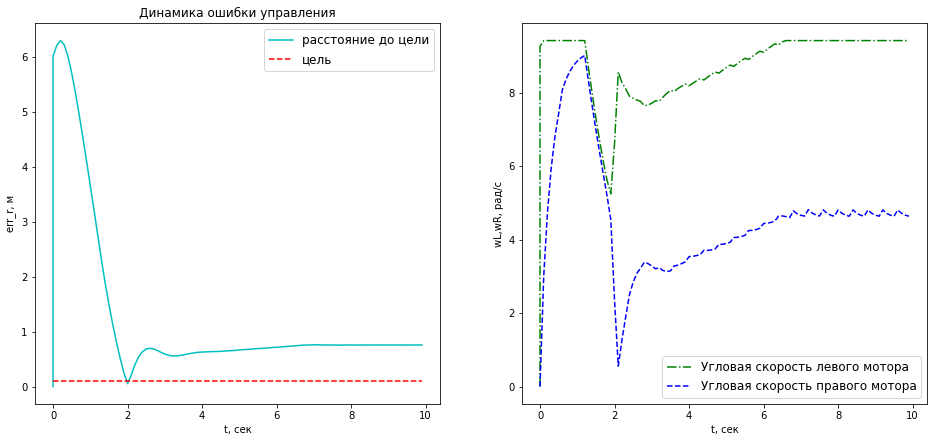

In [42]:
S_trace = robot_state.T  # считываем трассировку динамики состояний робота
U_trace = regul_trace.T      # считываем трассировку управлений
err_r_trace = np.vstack([U_trace[0], U_trace[6]]) # запоминаем динамику ошибки по расстоянию

# отрисовываем динамику скоростей и управляющих воздействий
drawErrorDynamic(err_r_trace, U_trace, {'eps_r':goal_precision})


#### ВЫВОД 1. При заданных значениях параметров регуляторов мы добиваемся заданной точности примерно за 4 сек (40 шагов управления). Сначала оба колеса включаются на чуть больше половинной мощности (правое больше), а затем после поворота и выхода на директрису они начинают замедляться, пока не останавливаются полностью после 6 сек движения.

### 3. Визуализация траектории движения робота

In [43]:
goal_state.shape

(101, 4)

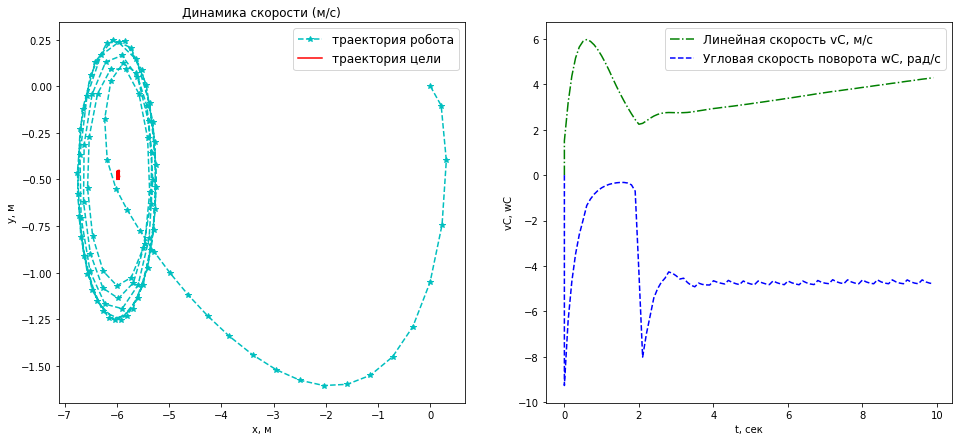

In [44]:
S_trace = robot_state.T  # считываем трассировку динамики состояний робота
rgoal = goal_state[:, 1:3]
G_trace0 = (0.05*np.random.random((len(S_trace[0]), 2)) + rgoal).T  # имитируем динамику состояний цели для парковки
G_trace = np.vstack([S_trace[0], G_trace0])  # для парковки

#G_trace = GOAL_state.T  # для ловли зайца


drawDynamic2D(S_trace[1:3], G_trace[1:3], U_trace, Pars={})

#### ВЫВОД 3. Видим, что при заданных значениях параметров регулятора траектория сильно отклоняется от оптимальной

### 4. Оценка скорости сходимости последовательности приближений

Среднее значение последовательности относительных коэффициентов уменьшения ошибки=  0.99


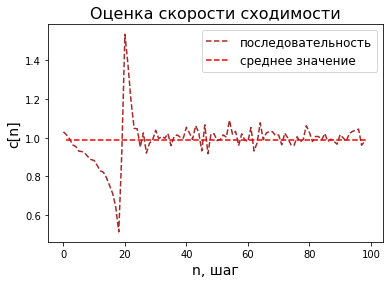

Средняя скорость сходимости последовательности =   1.01


In [45]:
# Вычислим последовательность относительных коэффицентов уменьшения ошибки: cc(n)=|V(n+1)-Vdir|/|V(n)-Vdir|
cc = analysStrace_2(S_trace, G_trace, eps= goal_precision)
print('Среднее значение последовательности относительных коэффициентов уменьшения ошибки={:6.2f}'.format(np.mean(cc)))

# Проанализируем график изменения cc[n]
show_convergence_rate_plot(cc)
#print(cc[-5:])
v_mean = 1/np.mean(cc)
print('Средняя скорость сходимости последовательности = {:6.2f}'.format(v_mean))

#### ВЫВОД 4. При заданных значениях параметров регулятора средняя скорость сходимости составила ...

### ВЫВОД: Нужной траектории робота для его парковки можно добиться с использованием П-регуляторов, на основе ошибки по углу и по расстоянию. Для успешности парковки необходимо учитывать следующие моменты:
1)...
2)...